In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from pynverse import inversefunc

from nicks_plot_utils import *
from lmfit import Model
from lmfit.models import *
from tqdm import tqdm
import logging
logging.getLogger().setLevel(logging.CRITICAL)

COLOR_BLUE=plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
COLOR_RED=plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COLOR_DGREEN=plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
plt.rcParams['legend.title_fontsize'] = 'xx-small'

overlapSettings = {"E99-107": {"name": "E99-107",
                               "color": COLOR_RED,
                               "symbol": '*',
                               "ms" : 10},
                   "kijun": {"name": "K. Park 2014",
                                    "color": COLOR_DGREEN,
                                    "symbol": 'd',
                                "ms": 6},
                   }

which_plot = {
    -1.0: [0, 0],
    -0.8: [0, 1],
    -0.6: [1, 0],
    -0.4: [1, 1],
    -0.2: [2, 0],
    0.0: [2, 1],
    0.2: [3, 0],
    0.4: [3, 1],
    0.6: [4, 0],
    0.8: [4, 1]
}
plot_label = {
    -1.0: "$\cos(\\theta)=[-1.0,-0.8)$",
    -0.8: "$\cos(\\theta)=[-0.8,-0.6)$",
    -0.6: "$\cos(\\theta)=[-0.6,-0.4)$",
    -0.4: "$\cos(\\theta)=[-0.4,-0.2)$",
    -0.2: "$\cos(\\theta)=[-0.2,0.0)$",
    0.0: "$\cos(\\theta)=[0.0,0.2)$",
    0.2: "$\cos(\\theta)=[0.2,0.4)$",
    0.4: "$\cos(\\theta)=[0.4,0.6)$",
    0.6: "$\cos(\\theta)=[0.6,0.8)$",
    0.8: "$\cos(\\theta)=[0.8,1.0)$"
}

from maid_interface import maid_2007_Npi as maid

xs = np.linspace(0,2*np.pi,200)

TOPFAC = 1.5

def get_maid_values(w, q2, theta):
    ENERGY = 4.81726
    crossSections = []
    for phi in xs:
        crossSections.append(maid(ENERGY, w, q2, theta, np.degrees(phi)))

    return np.array(crossSections)


def plot_maid_model(ax, w, q2, theta, name=""):
    # Get the cross section values from maid
    crossSections = get_maid_values(w, q2, theta+0.1)
    # _ax = ax.twinx()
    ax.plot(xs, crossSections, c='r', linestyle='dotted', label=f"{name}")
    # ax.set_ylim(bottom=0, top=np.max(crossSections)*1.5)

    return np.max(crossSections)*TOPFAC


def A(M, B, C):
    if (C > 0 and np.abs(B) <= 4*C):
        return M**2 + B**2/(8*C) + C
    else:
        return M**2 + np.abs(B) - C
    

def model(x, M, b, c):
    """
    a => sigma_l + sigma_t
    b => epsilon*sigma_tt
    c => Sqrt(2epsilon(1+epsilon))* sigma_lt
    """
    f = A(M, b, c) + b * np.cos(2*x) + c * np.cos(x)
    return f

def fit_model(ax, x, y, color, func=model):
    # Make model from function
    model = Model(func)
    # Make fit parameters
    params = model.make_params()
    # Make sure to set inital values to 1
    # so fit doesn't fail
    for p in params:
        params[p].set(value=1)

    # Fit the model
    try:
        out = model.fit(y, params, x=x)
    except ValueError as e:
        print(e)
        return None
    except TypeError as e:
        print(e)
        return None

    # Plot the fitted model with output parameters and same x's as model
    ax.plot(xs, out.eval(params=out.params, x=xs),
            linewidth=2.0, c=color, alpha=0.2)

    return out


In [2]:
dfall = pd.read_csv("/Users/tylern/Data/e1d/crossSections/full_results.csv", index_col=0)
dfall.head()

dfhighw = pd.read_csv("/Users/tylern/Data/e1d/crossSections/results_highw.csv", index_col=0)
dfhighw.head()

df = pd.concat([dfall,dfhighw])

In [3]:
ws = df.w_left.unique()
q2s = df.q2_left.unique()
cts = df.cos_theta.unique()

In [4]:
q2s

array([1.1 , 1.33, 1.56, 1.87, 2.23, 2.66, 1.8 , 2.2 , 2.6 , 3.15])

In [5]:
def plotCos(w, q2):
    data1 = df[(df.w_left == w) & (df.q2_left == q2)]
    fits = []
    try:
        w_left = data1.w_left.iloc[0]
        w_right = data1.w_right.iloc[0]
        q2_left = data1.q2_left.iloc[0]
        q2_right = data1.q2_right.iloc[0]
    except IndexError:
        w_left = np.nan
        w_right = np.nan
        q2_left = np.nan
        q2_right = np.nan
    
    # fig, axs = plt.subplots(nrows=5,ncols=2, figsize=[20,10],)
    for ct in cts:
        data =  data1[(data1.cos_theta == ct)]
        #a = which_plot[ct][0]
        #b = which_plot[ct][1]
        #ax = axs[which_plot[ct][0],which_plot[ct][1]]
        #if len(data) == 0:
        #    ax.set_visible(False)
        #    continue


        errorCut = (data.err < 0.75)
        #if np.sum(errorCut) < 4:
        #    ax.set_visible(False)
        #    continue
        # ebar = ax.errorbar(data[errorCut].x, data[errorCut].y, yerr=data[errorCut].err, fmt='.', markersize=10)
        # plt.errorbar(data[~errorCut].x, data[~errorCut].y, yerr=data[~errorCut].err, fmt='.', markersize=10, label=f"$\cos(\\theta)$ [{ct},{ct+0.2:0.1f})")

        out = fit_model(ax, data[errorCut].x, data[errorCut].y, ebar[0].get_color())
        
        fits.append({
            "w_left" : w_left,
            "q2_left" : q2_left,
            "cos_theta_left" : ct,
            "A" : A(out.params['M'],out.params['b'], out.params['c']),
            "B" : out.params['b'].value,
            "C" : out.params['c'].value,
        })
        

        # maid_top = plot_maid_model(ax, w, q2, ct)


        # ax.legend(loc='upper right',fontsize='xx-small', title=f'{plot_label[ct]}')
        # ax.set_ylabel(r'$\frac{\mathbf{d}\sigma}{\mathbf{d} \Omega} \left[\frac{\mu b}{sr}\right]$')
        # ax.set_xlabel(r'$\phi_{\pi}^{*}$')
        # plt.suptitle(f"$W~:~[{w_left},{w_right})~GeV~~~Q^2~:~[{q2_left},{q2_right})~GeV^2~$", fontsize=20)

        #try:
        #    top = np.max(data[errorCut].y)*TOPFAC
        #except ValueError:
        #    top = np.nan


        #if np.isnan(top) or np.isinf(top):
        #    ax.set_ylim(bottom=0, top=1.0)
        #else:
        #    ax.set_ylim(bottom=0, top=max(top, maid_top))

    
    # plt.xlim(0, 2*np.pi)
    # plt.show()
    # fig.savefig(f"/Users/tylern/Desktop/show/plots/e1d/plots/crossSections/cost_w_{w_left:0.3f}_q2_{q2_left:0.3f}.png", 
    # bbox_inches='tight', dpi=250, transparent=False)
    
    return pd.DataFrame(fits)

100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


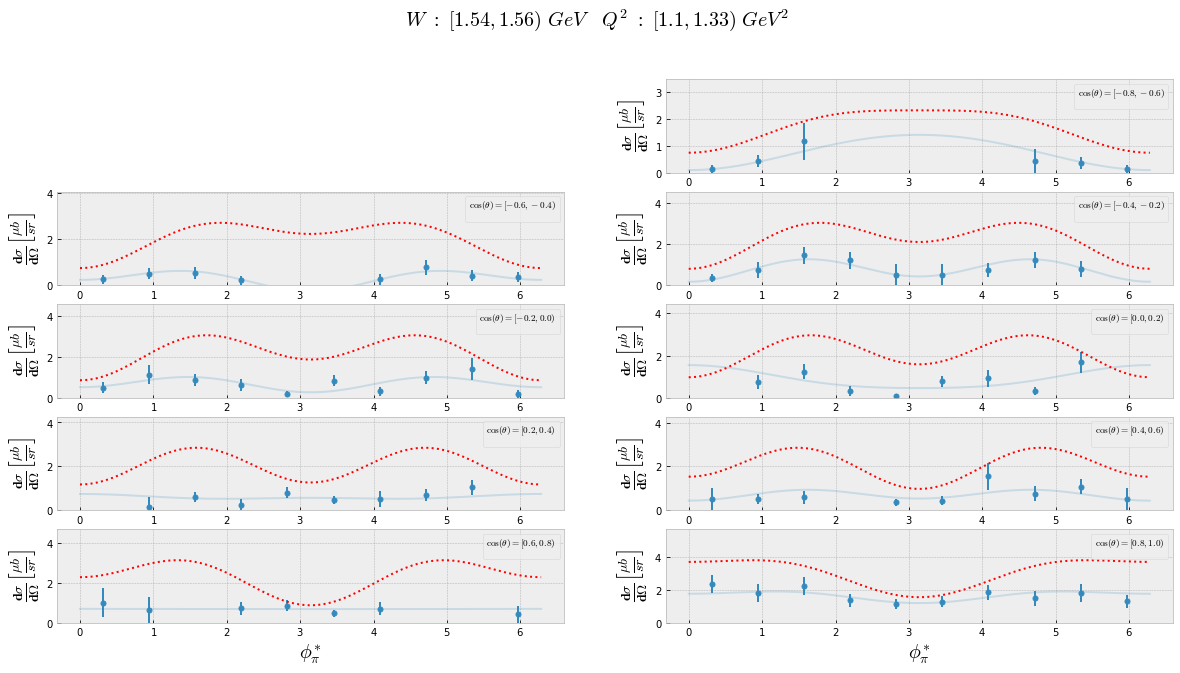

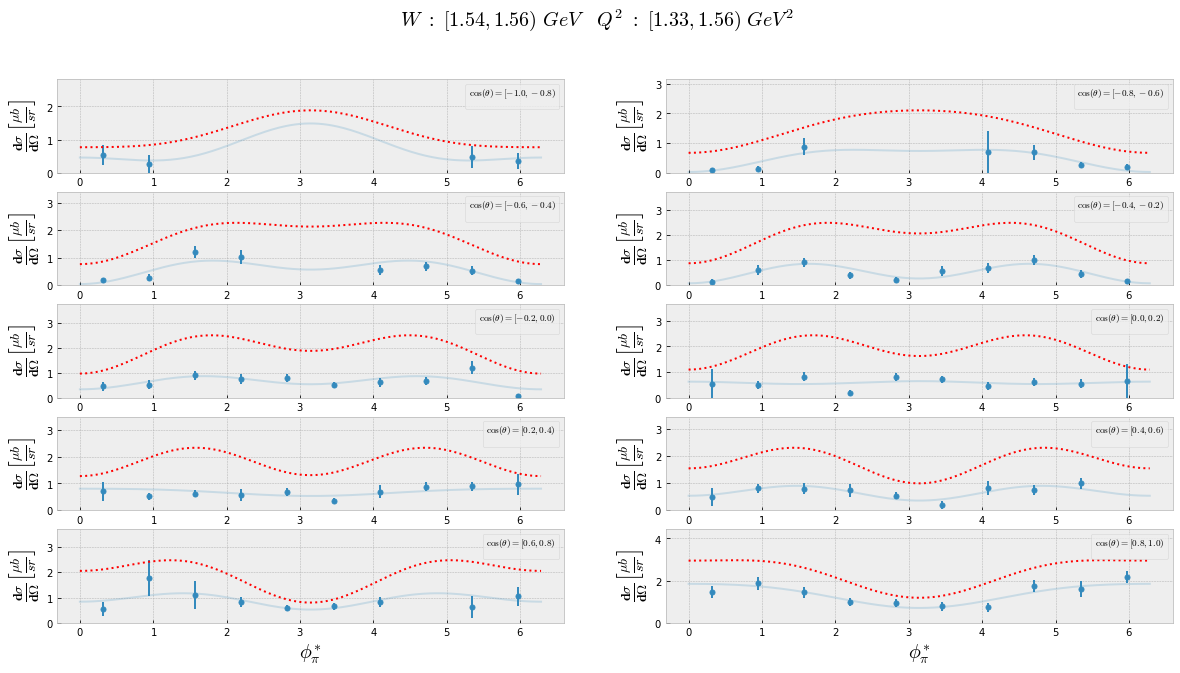

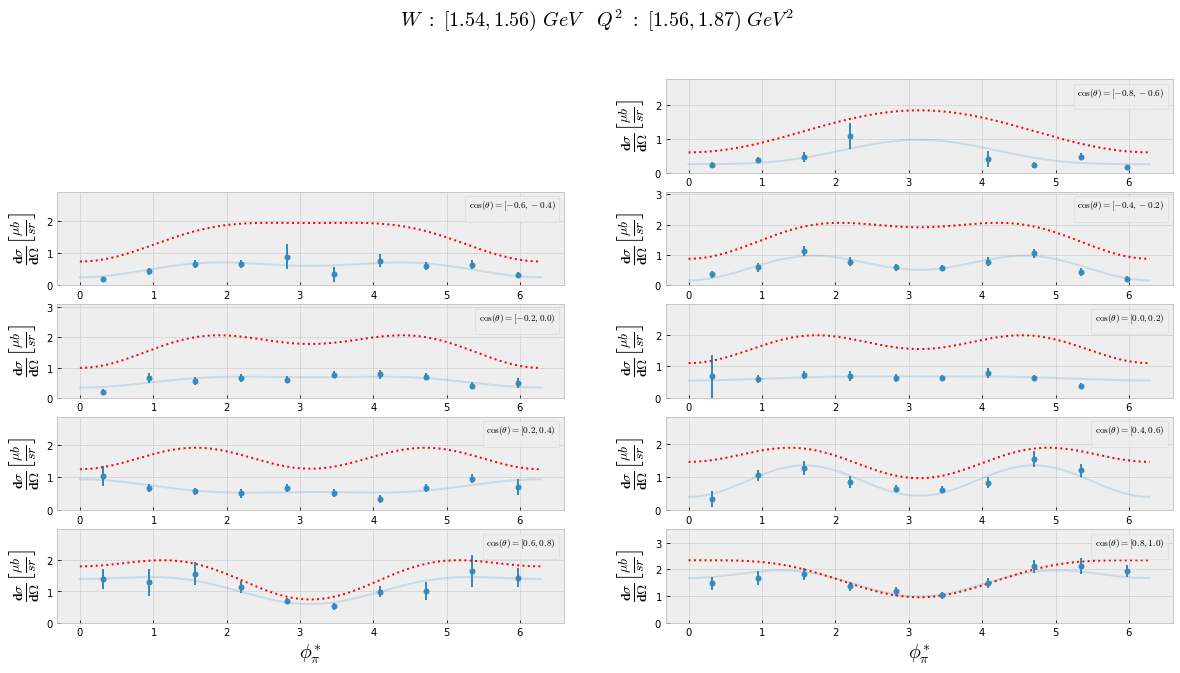

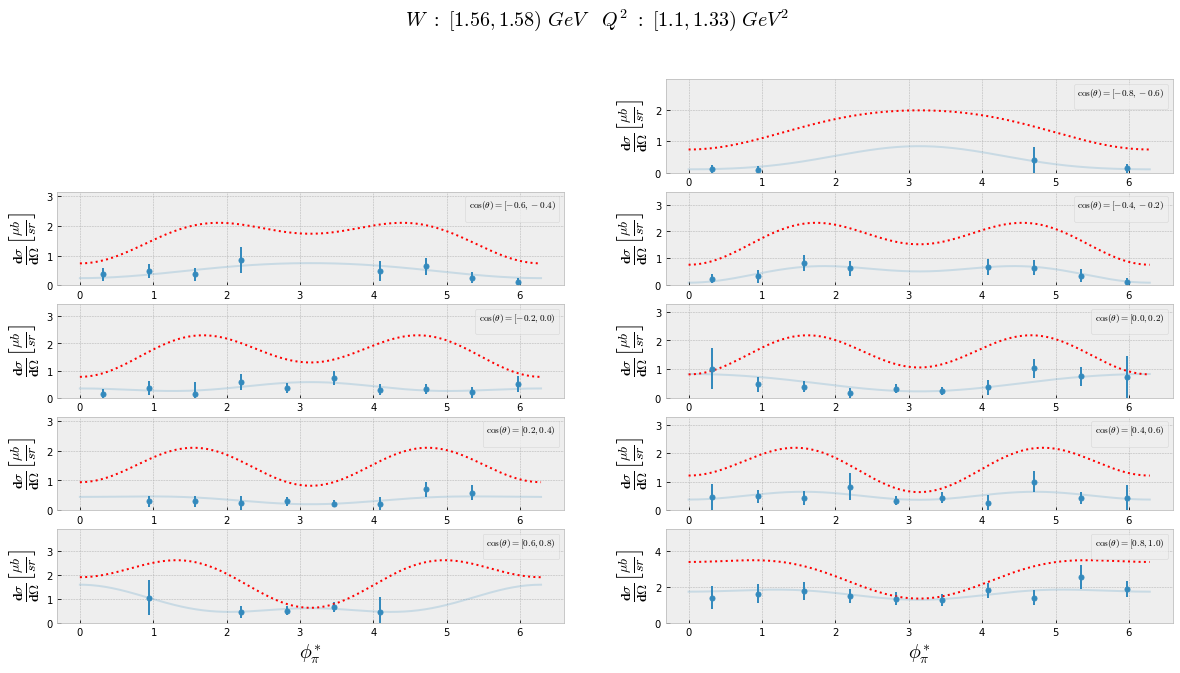

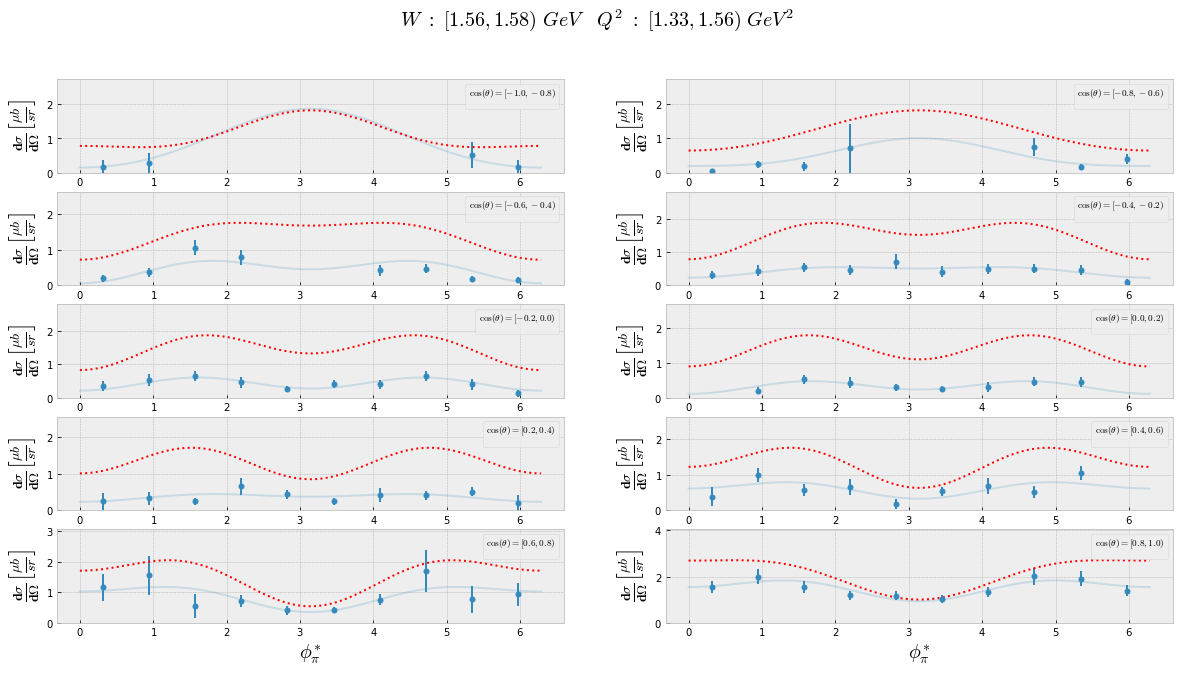

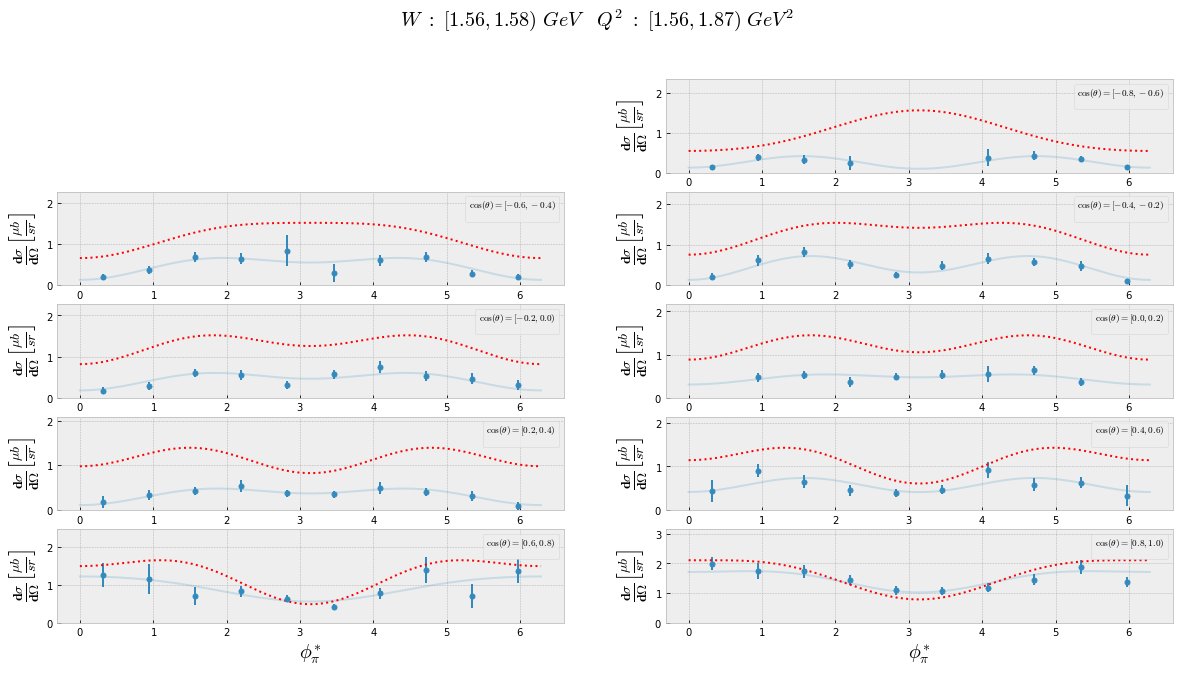

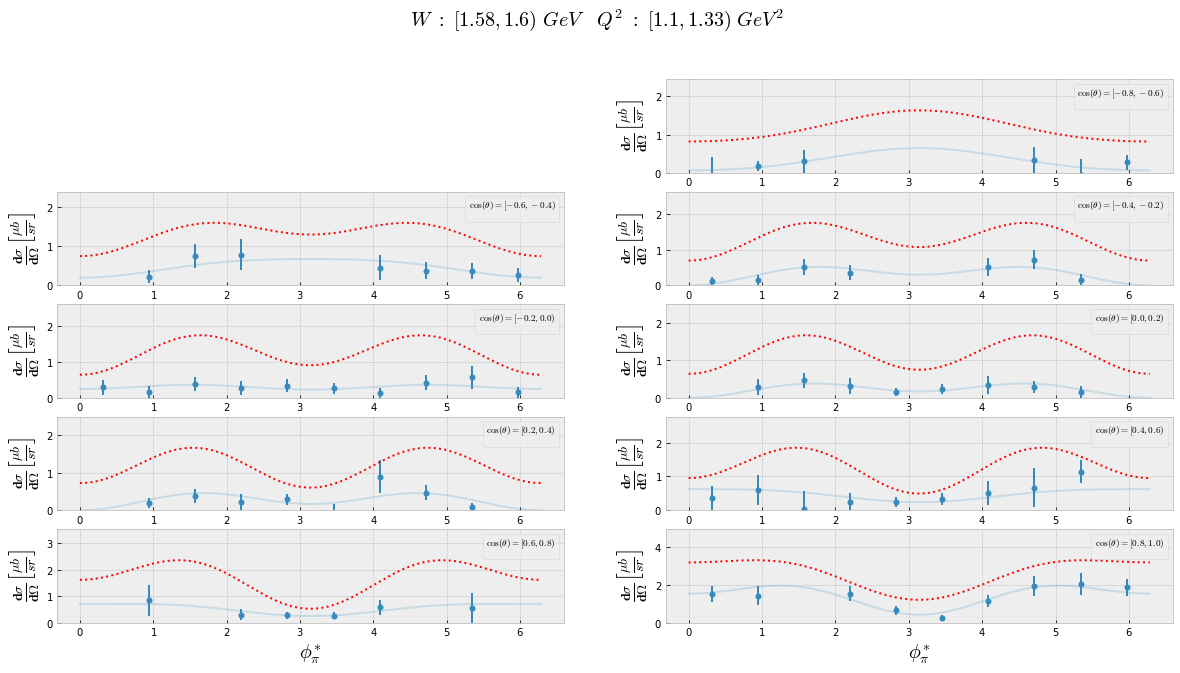

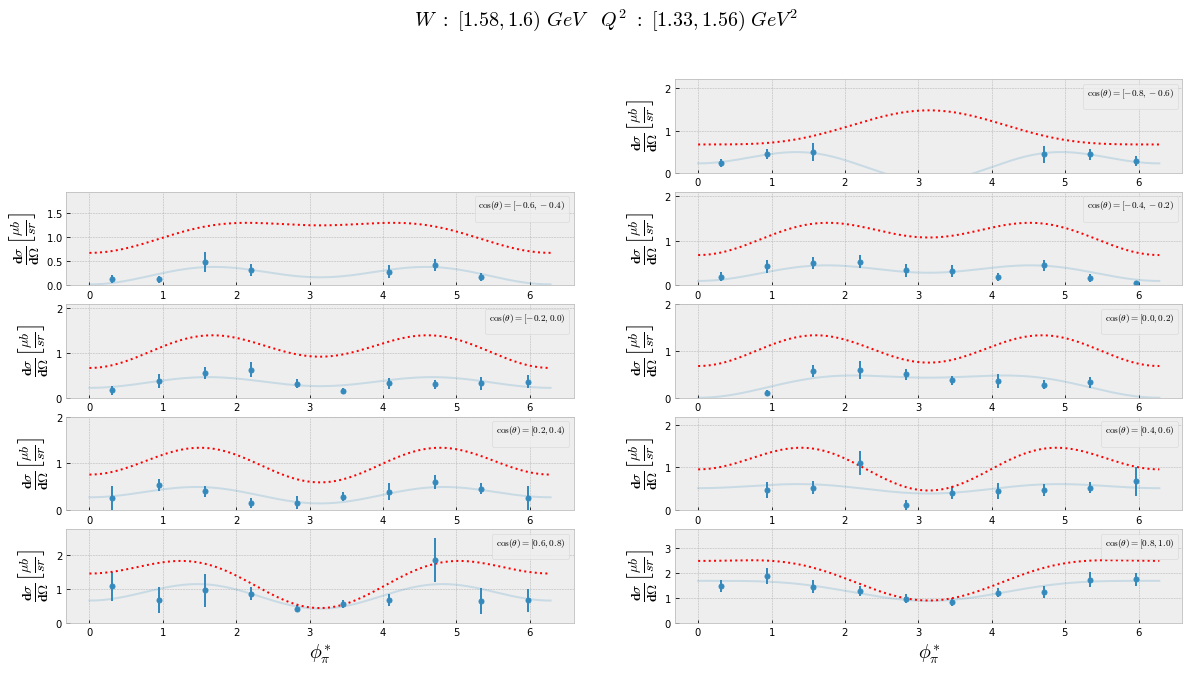

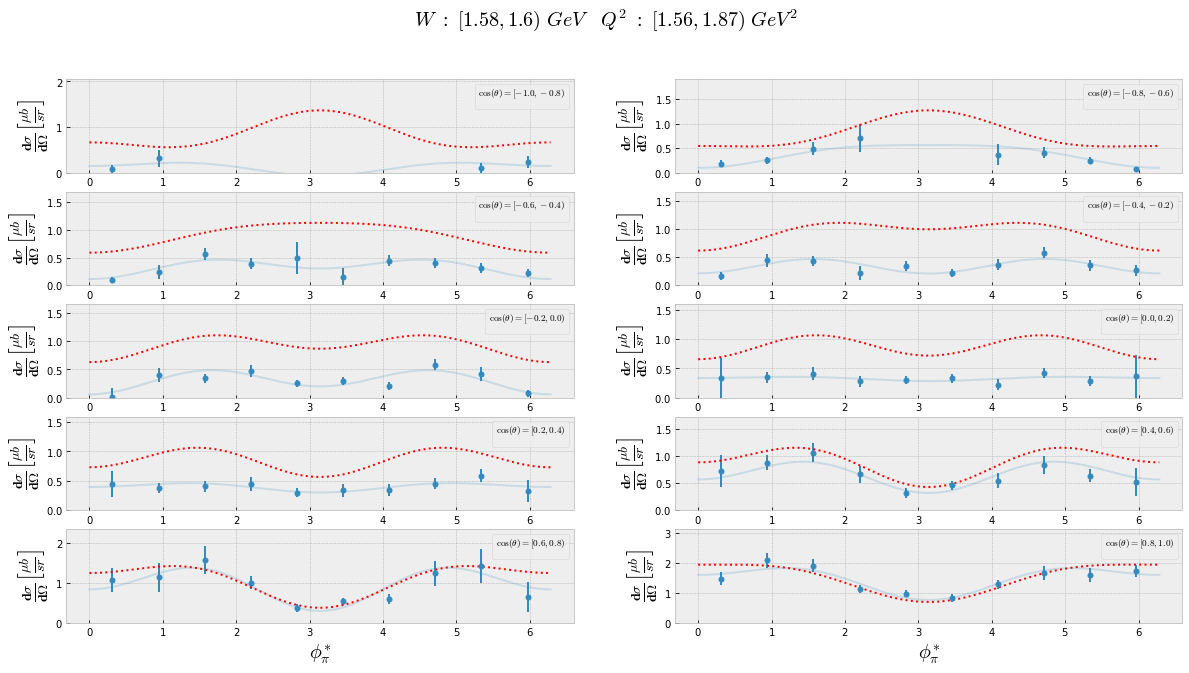

In [6]:
fits = []
for w in tqdm([1.54 , 1.56 , 1.58]):
    for q2 in [1.1, 1.33, 1.56]:
        fits.append(plotCos(w, q2))

fits_df = pd.concat(fits)

In [7]:
fits[0]

,w_left,q2_left,cos_theta_left,A,B,C
0,1.54,1.1,-0.4,0.777742,-0.476876,-0.127099
1,1.54,1.1,-0.2,0.701996,-0.309354,0.124139
2,1.54,1.1,0.0,0.911829,0.090731,0.545273
3,1.54,1.1,0.2,0.595969,0.057622,0.088715
4,1.54,1.1,0.4,0.709008,-0.223462,-0.047555
5,1.54,1.1,0.6,0.686327,-0.000899,0.006457
6,1.54,1.1,0.8,1.668279,-0.184690,0.285167
7,1.54,1.1,-0.8,0.776393,-0.024135,-0.651344
8,1.54,1.1,-0.6,0.298675,-0.304299,0.241601


  0%|          | 0/3 [00:00<?, ?it/s]

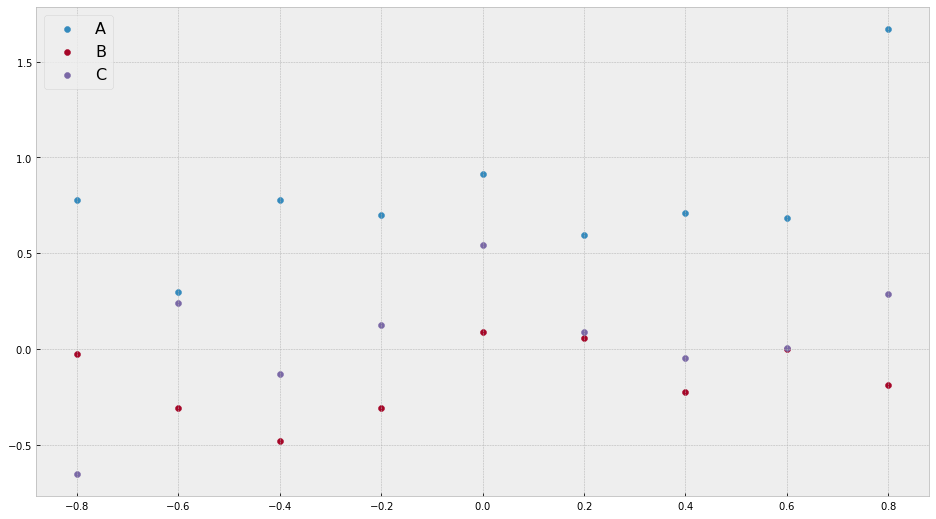

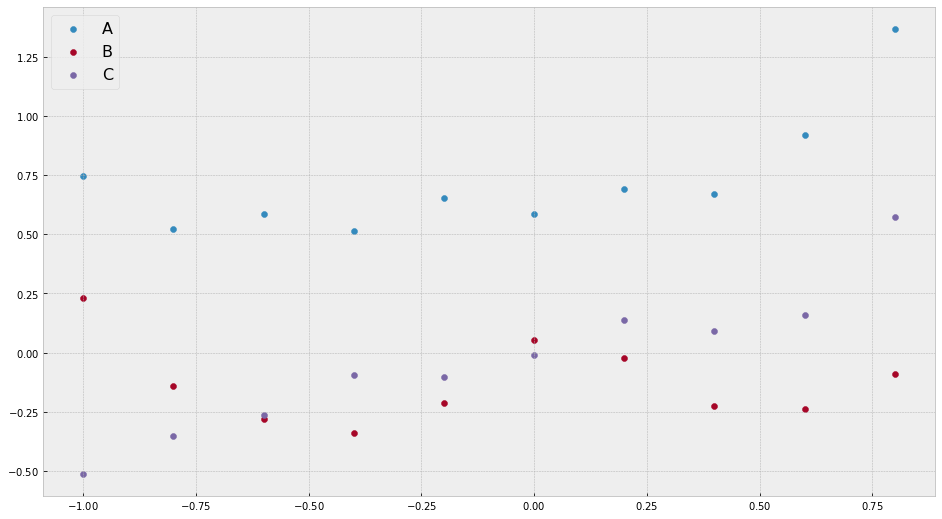

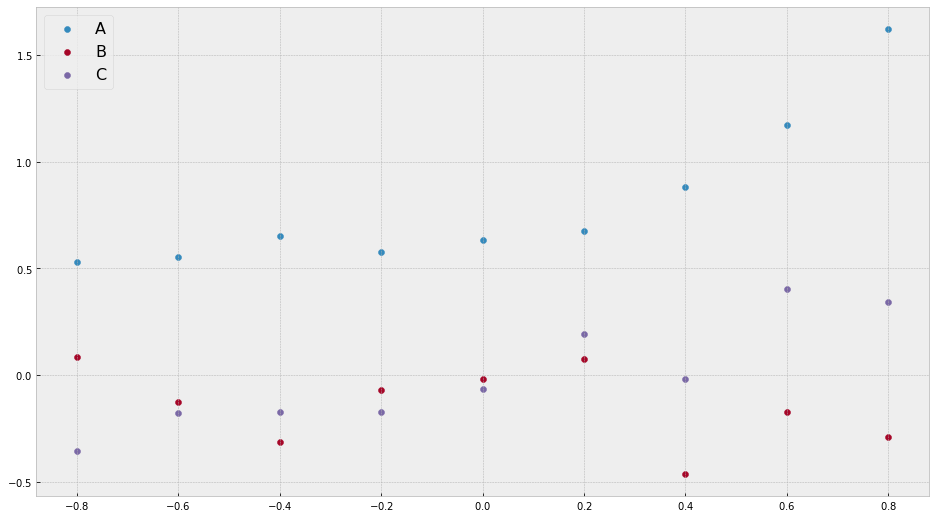

 33%|███▎      | 1/3 [00:01<00:02,  1.08s/it]

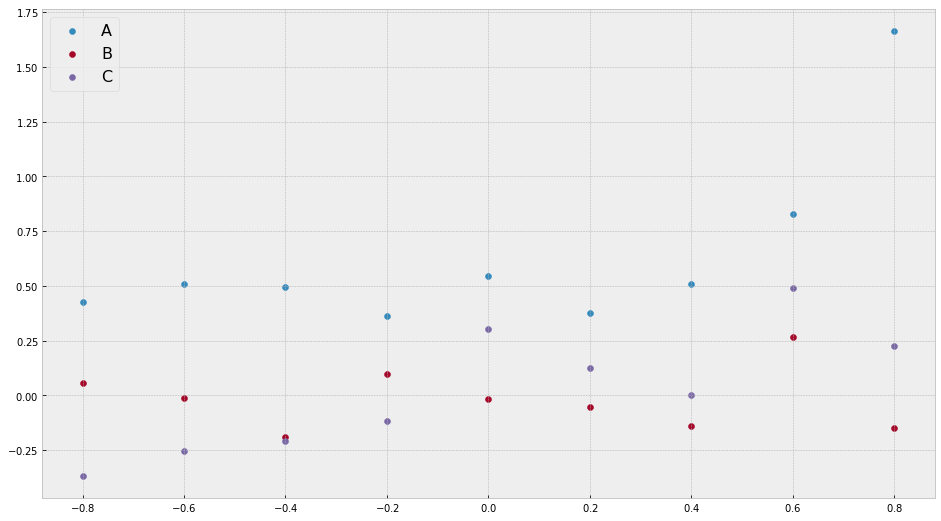

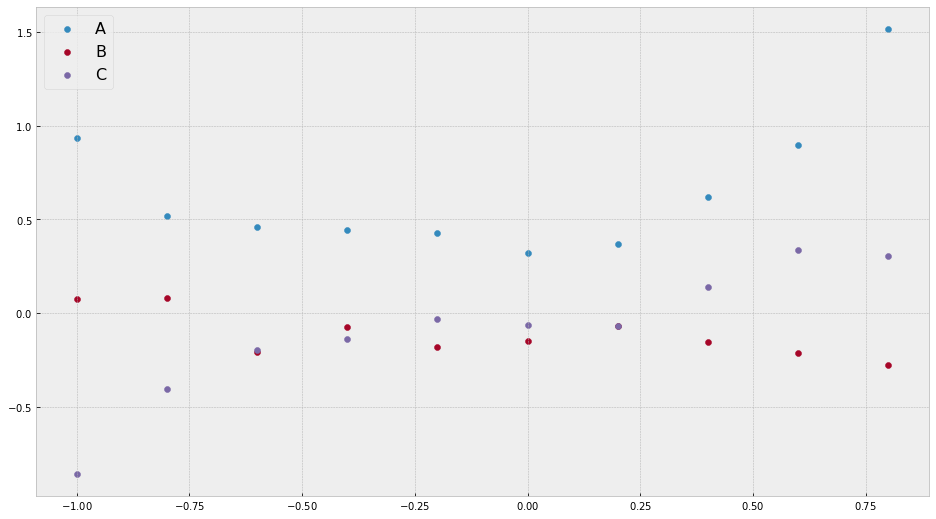

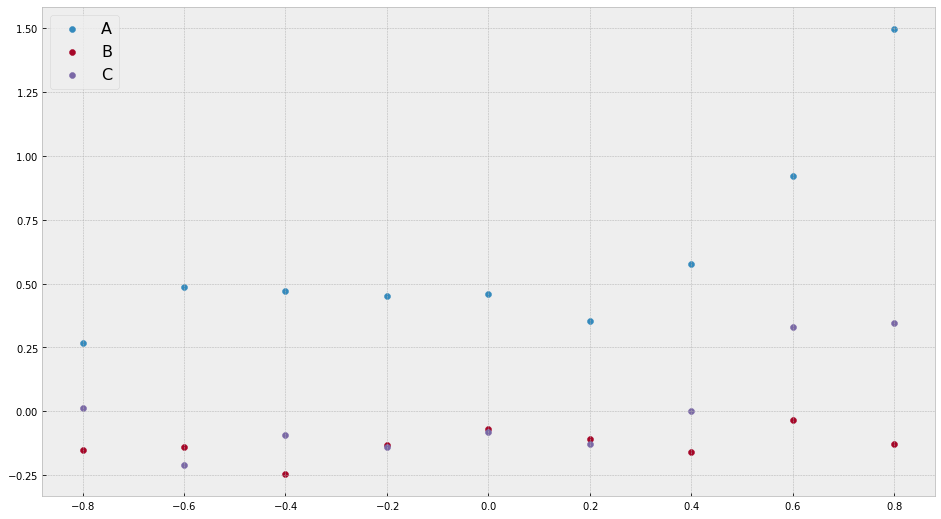

 67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

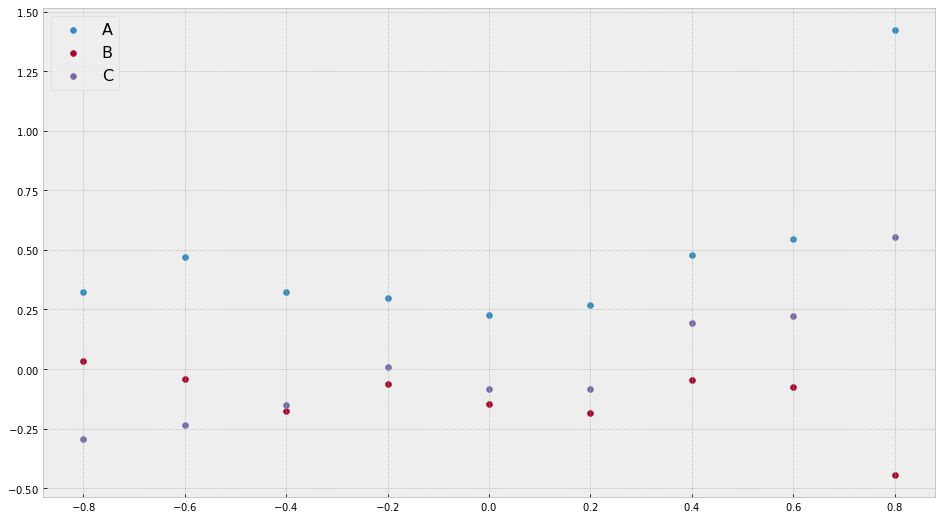

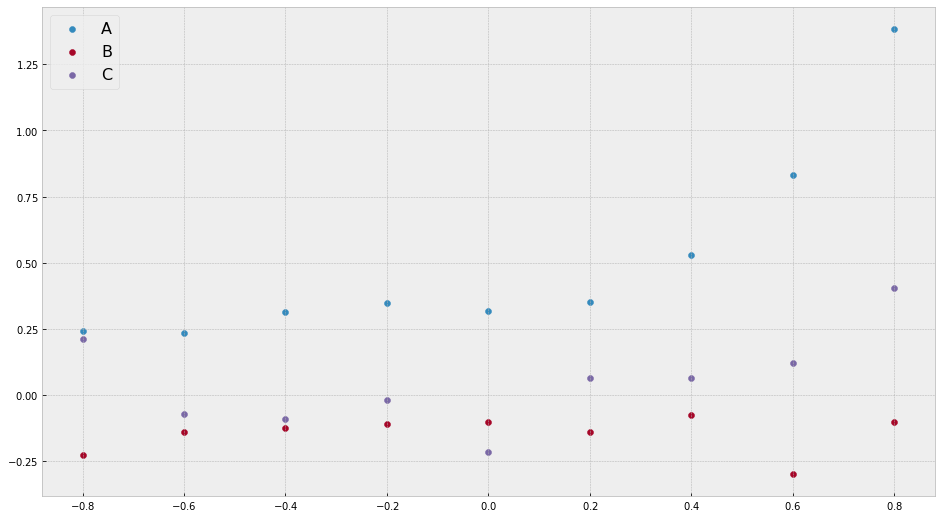

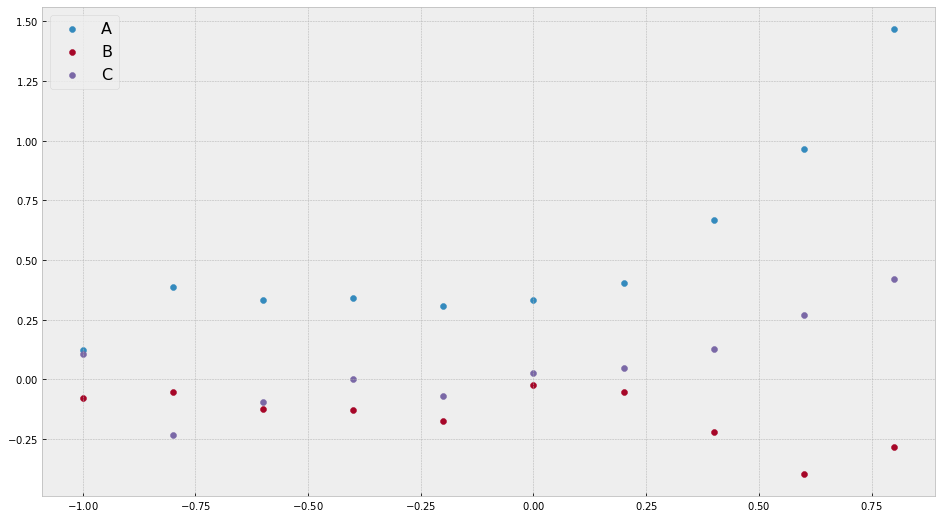

100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


In [10]:
for w in tqdm([1.54 , 1.56 , 1.58]):
    for q2 in [1.1, 1.33, 1.56]:
        data = fits_df[(fits_df.w_left == w) & (fits_df.q2_left == q2)]
        
        plt.scatter(data.cos_theta_left, data.A, label="A")        
        plt.scatter(data.cos_theta_left, data.B, label="B")        
        plt.scatter(data.cos_theta_left, data.C, label="C")
        
        plt.legend()
        plt.show()
        